In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
tf.keras.utils.set_random_seed(3)
from tqdm import tqdm
from tensorflow.keras.utils import plot_model
import tensorflow_probability as tfp
import time

In [2]:
import gc

In [3]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, accuracy_score

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data

In [5]:
BASE_PATH = "/content/drive/MyDrive/Cursos/TFM_AI/TFM/aplicacion/" #""
train_path = BASE_PATH + "data/train.npz"
test_path = BASE_PATH + "data/test.npz"
classifier_path = BASE_PATH + "models/classifier.h5"

cvae_path = BASE_PATH + "models/cvae.h5"

cvae_cgan_path = BASE_PATH + "models/cvae-cgan_no_noise.h5"

#vq_vae
vq_vae_path = BASE_PATH + "models/vq_vae.h5"
pixelcnn_model_path = BASE_PATH + "models/vq_vae_pixelcnn.h5"

#vq_vae2
vq_vae2_path = BASE_PATH+"models/vq_vae2.h5"
pixelcnnt_model_path = BASE_PATH+"models/vq_vae2_Gpixelcnn_top.h5"
#pixelcnnb_model_path = BASE_PATH+"models/vq_vae2_Gpixelcnn_bottom.h5"

#vq_vae2_new_bottom
pixelcnnb_model_path_i2 = BASE_PATH+"models/vq_vae2_Gpixelcnn_bottom_i2.h5"

In [6]:
train_data = np.load(train_path)
X_train = train_data["arr_0"]
y_train = train_data["arr_1"]
X_train.shape, y_train.shape

((10000, 128, 128, 1), (10000,))

In [7]:
test_data = np.load(test_path)
X_test = test_data["arr_0"]
y_test = test_data["arr_1"]
X_test.shape, y_test.shape

((400, 128, 128, 1), (400,))

In [8]:
X_train = X_train / 255.
X_test = X_test / 255.

# Classifier

In [9]:
images_shape = X_test.shape[1:]
images_shape

(128, 128, 1)

In [10]:
classifier = keras.models.load_model(classifier_path)

In [11]:
classifier.evaluate(X_test, y_test)

13/13 [==============================] - 10s 82ms/step - loss: 0.2476 - accuracy: 0.9175


[0.2476218342781067, 0.9175000190734863]

In [12]:
y_pred = classifier.predict(X_test)
y_pred = np.round(y_pred.squeeze())

13/13 [==============================] - 1s 29ms/step


In [13]:
target_names = ["Negative", "Positive"]

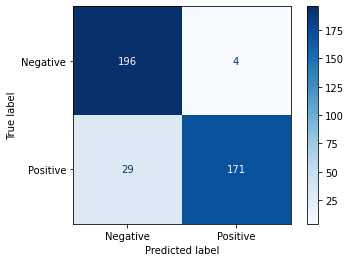

In [14]:
"""
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
disp.plot()
plt.show()
"""
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues, display_labels=target_names)

In [15]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.87      0.98      0.92       200
    Positive       0.98      0.85      0.91       200

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400



Remember:  
precision = TP/(TP+FP) #for the class Positive it would be 171/(171+4)  
recall = TP/(TP+FN) #for the class Positive it would be 171(171+29)

## Classifying CVAE

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
vae = keras.models.load_model(cvae_path, custom_objects={'Sampling': Sampling}, compile=False)
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 encoder (Functional)           [(None, 32),         2255296     ['input_3[0][0]',                
                                 (None, 32),                      'input_4[0][0]']                
                                 (None, 32)]                                                    

In [ ]:
decoder = vae.get_layer("decoder")
latent_dim = 32

In [ ]:
batch = 400
classes = np.hstack([np.zeros((batch//2), dtype=np.uint8), np.ones((batch//2), dtype=np.uint8)])
ruido = np.random.randn(batch, latent_dim)
gen_imgs = decoder.predict([ruido, classes])
gen_imgs.shape

13/13 [==============================] - 1s 25ms/step


(400, 128, 128, 1)

In [ ]:
classifier.evaluate(gen_imgs, classes)

13/13 [==============================] - 1s 41ms/step - loss: 2.3858 - accuracy: 0.5050


[2.385761022567749, 0.5049999952316284]

In [ ]:
y_pred = classifier.predict(gen_imgs)
y_pred = np.round(y_pred.squeeze())

13/13 [==============================] - 0s 36ms/step


              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67       200
    Positive       1.00      0.01      0.02       200

    accuracy                           0.51       400
   macro avg       0.75      0.51      0.34       400
weighted avg       0.75      0.51      0.34       400



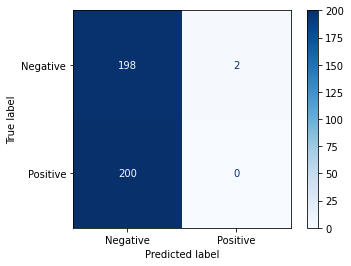

In [ ]:
"""
cm = confusion_matrix(classes, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
disp.plot()
plt.show()
"""
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues, display_labels=target_names)
print(classification_report(classes, y_pred, target_names=target_names))

## Classifying CVAE-CGAN

In [ ]:
vae = keras.models.load_model(cvae_cgan_path, custom_objects={'Sampling': Sampling}, compile=False)
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 encoder (Functional)           [(None, 32),         2255296     ['input_3[0][0]',                
                                 (None, 32),                      'input_4[0][0]']                
                                 (None, 32)]                                                    

In [ ]:
decoder = vae.get_layer("decoder")
#encoder = vae.get_layer("encoder")

In [ ]:
latent_dim = 32

In [ ]:
batch = 400
classes = np.hstack([np.zeros((batch//2), dtype=np.uint8), np.ones((batch//2), dtype=np.uint8)])
ruido = np.random.randn(batch, latent_dim)
gen_imgs = decoder.predict([ruido, classes])
gen_imgs.shape

13/13 [==============================] - 0s 12ms/step


(400, 128, 128, 1)

In [ ]:
classifier.evaluate(gen_imgs, classes)

13/13 [==============================] - 1s 45ms/step - loss: 1.5160 - accuracy: 0.6325


[1.5160373449325562, 0.6324999928474426]

In [ ]:
y_pred = classifier.predict(gen_imgs)
y_pred = np.round(y_pred.squeeze())

13/13 [==============================] - 0s 37ms/step


              precision    recall  f1-score   support

    Negative       0.58      0.94      0.72       200
    Positive       0.84      0.33      0.47       200

    accuracy                           0.63       400
   macro avg       0.71      0.63      0.60       400
weighted avg       0.71      0.63      0.60       400



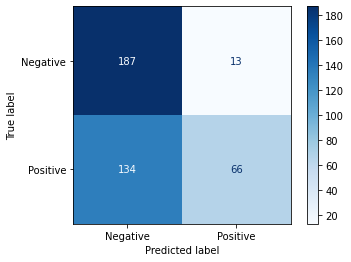

In [ ]:
"""
cm = confusion_matrix(classes, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
disp.plot()
plt.show()
"""
ConfusionMatrixDisplay.from_predictions(classes, y_pred, cmap=plt.cm.Blues, display_labels=target_names)
print(classification_report(classes, y_pred, target_names=target_names))

## Classifying VQ-VAE

In [16]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened) #aquí calcula el punto más cercano del embedding al x
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        codebook_indices = tf.reshape(encoding_indices, input_shape[:-1])

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized, codebook_indices

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices
    
    def quantize_from_priors(self, priors): #is will be used for generation with pixelcnn
        priors_ohe = tf.one_hot(priors.astype("int32"), self.num_embeddings).numpy()
        quantized = tf.matmul(priors_ohe.astype("float32"), self.embeddings, transpose_b=True)
        return np.squeeze(quantized)
    
    def get_config(self): #Need this part to be able to save in .h5
        config = super().get_config() #.copy()
        config.update({
            'num_embeddings': self.num_embeddings,
            'embedding_dim': self.embedding_dim,
            'beta': self.beta
        })
        return config

In [ ]:
vq_vae = keras.models.load_model(vq_vae_path, custom_objects={'VectorQuantizer': VectorQuantizer}, compile=False)
vq_vae.summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 encoder (Functional)        (None, 32, 32, 8)         1175656   
                                                                 
 vector_quantizer (VectorQua  ((None, 32, 32, 8),      128       
 ntizer)                      (None, 32, 32))                    
                                                                 
 decoder (Functional)        (None, 128, 128, 1)       1192033   
                                                                 
Total params: 2,367,817
Trainable params: 2,365,897
Non-trainable params: 1,920
_________________________________________________________________


In [ ]:
encoder = vq_vae.get_layer("encoder")
quantizer = vq_vae.get_layer("vector_quantizer")
decoder = vq_vae.get_layer("decoder")

In [ ]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, filters, kernel_size=3, activation=None, padding="valid", **kwargs):
        super().__init__(**kwargs)
        self.mask_type = mask_type
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation
        self.padding = padding
        self.conv = layers.Conv2D(self.filters, kernel_size=kernel_size, activation=activation, padding=padding)

    def build(self, input_shape): #override 
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs): #override 
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)
    
    #override 
    def get_config(self): #in order to be able to save and load
        config = super().get_config()
        config.update({
            "mask_type": self.mask_type,
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            "activation": self.activation,
            "padding": self.padding
        })
        return config


# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "filters": self.filters,
        })
        return config

In [ ]:
pixel_cnn = keras.models.load_model(pixelcnn_model_path, 
                                    custom_objects={"PixelConvLayer": PixelConvLayer, 
                                                    "ResidualBlock":ResidualBlock})

In [ ]:
pixel_cnn.summary()

Model: "pixel_cnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 32, 32)]     0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1024)         2048        ['input_15[0][0]']               
                                                                                                  
 tf.one_hot_1 (TFOpLambda)      (None, 32, 32, 16)   0           ['input_14[0][0]']               
                                                                                          

In [ ]:
pixelcnn_input_shape = (32,32)

In [ ]:
# Create a mini sampler model.
inputs = layers.Input(shape=pixelcnn_input_shape)
inputs_cond = layers.Input(shape=())
outputs = pixel_cnn([inputs, inputs_cond], training=False)

categorical_layer = tfp.layers.DistributionLambda(tfp.distributions.Categorical)
outputs = categorical_layer(outputs)
sampler = keras.Model([inputs, inputs_cond], outputs)

In [ ]:
batch = 400
priors = np.zeros(shape=(batch,) + pixelcnn_input_shape)
batch, rows, cols = priors.shape

In [ ]:
cond_inp = np.hstack([np.zeros((batch//2), dtype=np.uint8), np.ones((batch//2), dtype=np.uint8)])
cond_inp

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
# Iterate over the priors because generation has to be done sequentially pixel by pixel.
for row in tqdm(range(rows)):
    for col in range(cols):
        # Feed the whole array and retrieving the pixel value probabilities for the next
        # pixel.
        probs = sampler.predict([np.expand_dims(priors,-1), cond_inp], verbose=0)
        # Use the probabilities to pick pixel values and append the values to the priors.
        probs = np.squeeze(probs)
        priors[:, row, col] = probs[:, row, col]

print(f"Prior shape: {priors.shape}")

100%|██████████| 32/32 [10:07<00:00, 18.98s/it]

Prior shape: (400, 32, 32)


In [ ]:
quantized = quantizer.quantize_from_priors(priors)
generated_samples = decoder.predict(quantized)

13/13 [==============================] - 1s 31ms/step


In [ ]:
classifier.evaluate(generated_samples, cond_inp)

13/13 [==============================] - 0s 34ms/step - loss: 1.1117 - accuracy: 0.7400


[1.1116509437561035, 0.7400000095367432]

In [ ]:
y_pred = classifier.predict(generated_samples)
y_pred = np.round(y_pred.squeeze())

13/13 [==============================] - 0s 31ms/step


              precision    recall  f1-score   support

    Negative       0.69      0.86      0.77       200
    Positive       0.82      0.61      0.70       200

    accuracy                           0.74       400
   macro avg       0.76      0.74      0.74       400
weighted avg       0.76      0.74      0.74       400



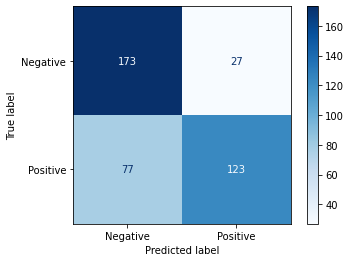

In [ ]:
"""
cm = confusion_matrix(cond_inp, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
disp.plot()
plt.show()
"""
ConfusionMatrixDisplay.from_predictions(cond_inp, y_pred, cmap=plt.cm.Blues, display_labels=target_names)
print(classification_report(cond_inp, y_pred, target_names=target_names))

## Classifying VQ-VAE2

In [17]:
vq_vae2 = keras.models.load_model(vq_vae2_path, custom_objects={'VectorQuantizer': VectorQuantizer}, compile=False)
vq_vae2.summary()

Model: "vq_vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 encoder_b (Functional)         (None, 32, 32, 8)    556488      ['input_22[0][0]']               
                                                                                                  
 encoder_t (Functional)         (None, 16, 16, 8)    560520      ['encoder_b[0][0]']              
                                                                                                  
 vector_quantizer_t (VectorQuan  ((None, 16, 16, 8),  128        ['encoder_t[0][0]']         

In [18]:
class MaskedConv2D(keras.layers.Layer):
    def __init__(self,mask_type,ver_or_hor,filters,kernel_size,**kwargs):
        super().__init__(**kwargs)

        assert mask_type in ['A', 'B']
        assert ver_or_hor in ["V", "H"]
        self.mask_type = mask_type
        self.ver_or_hor = ver_or_hor
        
        if ver_or_hor == 'H':  # 1XN mask
            self.pad = (0, (kernel_size - 1) // 2)
            ksz = (1, kernel_size)

        else:  # NxN mask vertical
            ksz = kernel_size
            self.pad = (kernel_size - 1) // 2

        self.filters = filters
        self.kernel_size = kernel_size
        self.conv = layers.Conv2D(filters,
                                  ksz,
                                  padding="valid")

    def build(self, input_shape):
        kernel_h = self.kernel_size
        kernel_w = self.kernel_size
        self.conv.build(input_shape)

        mask = np.zeros(self.conv.kernel.get_shape(), dtype=np.float32)

        if self.mask_type == "A":
            if self.ver_or_hor == "V":
                mask[:kernel_h // 2, ...] = 1
            else:
                mask[:, :kernel_w // 2, ...] = 1
        else: #B
            if self.ver_or_hor == "V":
                mask[:kernel_h // 2 + 1, ...] = 1
            else:
                mask[:, :kernel_w // 2 +1,...] = 1
        
        self.mask = tf.constant(mask, name='mask')

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        x = self.conv(inputs)
        return layers.ZeroPadding2D(self.pad)(x)

    def get_config(self): #Need this part to be able to save in .h5
        config = super().get_config() #.copy()
        config.update({
            'mask_type': self.mask_type,
            'ver_or_hor': self.ver_or_hor,
            'filters': self.filters,
            "kernel_size": self.kernel_size
        })
        return config

class GatedMaskedConv2d(layers.Layer):
    def __init__(self, mask_type, filters, kernel_size, **kwargs):
        super().__init__(**kwargs)

        self.mask_type = mask_type
        self.filters = filters
        self.kernel_size = kernel_size
        self.vertical_conv = MaskedConv2D(mask_type=mask_type, ver_or_hor="V",
                                        filters=2 * filters,
                                        kernel_size=kernel_size)

        self.horizontal_conv = MaskedConv2D(mask_type=mask_type, ver_or_hor="H",
                                            filters=2 * filters,
                                            kernel_size=kernel_size)

        self.v_to_h_conv = keras.layers.Conv2D(filters=2 * filters, kernel_size=1)

        self.horizontal_output = keras.layers.Conv2D(filters=filters, kernel_size=1)

    def _gate(self, x):
        tanh_preactivation, sigmoid_preactivation = tf.split(x, 2, axis=-1)
        return tf.nn.tanh(tanh_preactivation) * tf.nn.sigmoid(sigmoid_preactivation)

    def call(self, input_tensor):
        v, h = input_tensor

        vertical_preactivation = self.vertical_conv(v)
        horizontal_preactivation = self.horizontal_conv(h)

        v_to_h = self.v_to_h_conv(vertical_preactivation)
    
        v_out = self._gate(vertical_preactivation)

        horizontal_preactivation = horizontal_preactivation + v_to_h
        
        h_activated = self._gate(horizontal_preactivation)
        h_activated = self.horizontal_output(h_activated)

        if self.mask_type == 'A':
            h_out = h_activated
        elif self.mask_type == 'B':
            h_out = h + h_activated

        return v_out, h_out

    def get_config(self): #Need this part to be able to save in .h5
        config = super().get_config() #.copy()
        config.update({
            'mask_type': self.mask_type,
            'filters': self.filters,
            "kernel_size": self.kernel_size
        })
        return config

In [19]:
pixel_cnn_t = keras.models.load_model(pixelcnnt_model_path, 
                                    custom_objects={"MaskedConv2D": MaskedConv2D, 
                                                    "GatedMaskedConv2d": GatedMaskedConv2d})

pixel_cnn_b = keras.models.load_model(pixelcnnb_model_path_i2, 
                                    custom_objects={"MaskedConv2D": MaskedConv2D, 
                                                    "GatedMaskedConv2d": GatedMaskedConv2d})

In [20]:
encoder_t = vq_vae2.get_layer("encoder_t")
quantizer_t = vq_vae2.get_layer("vector_quantizer_t")
decoder_t = vq_vae2.get_layer("decoder_t")
encoder_b = vq_vae2.get_layer("encoder_b")
quantizer_b = vq_vae2.get_layer("vector_quantizer_b")
decoder_b = vq_vae2.get_layer("decoder_b")

In [21]:
batch = 400
cond_inp = np.hstack([np.zeros((batch//2), dtype=np.uint8), np.ones((batch//2), dtype=np.uint8)])

In [22]:
def get_t_sampler(input_shape=(16,16)):
    # Create a mini sampler model.
    inputs = layers.Input(shape=input_shape)
    inputs_cond = layers.Input(shape=())
    outputs = pixel_cnn_t([inputs, inputs_cond], training=False)
    categorical_layer = tfp.layers.DistributionLambda(tfp.distributions.Categorical)
    outputs = categorical_layer(outputs)
    return keras.Model([inputs, inputs_cond], outputs)
t_sampler = get_t_sampler()

In [23]:
def get_t_sample(sampler, labels):
    # Create an empty array of priors.
    batch = len(labels)
    input_shape=t_sampler.output.shape[1:]
    priors = np.zeros(shape=(batch,) + (input_shape))
    priors = np.squeeze(priors)
    batch, rows, cols = priors.shape
    cond_inp = labels
    # Iterate over the priors because generation has to be done sequentially pixel by pixel.
    for row in tqdm(range(rows)):
        for col in range(cols):
            # Feed the whole array and retrieving the pixel value probabilities for the next
            # pixel.
            probs = sampler.predict([np.expand_dims(priors,-1), cond_inp], verbose=0)
            # Use the probabilities to pick pixel values and append the values to the priors.
            probs = np.squeeze(probs)
            priors[:, row, col] = probs[:, row, col]
    return priors
sampled_t = get_t_sample(t_sampler, cond_inp)

100%|██████████| 16/16 [00:50<00:00,  3.17s/it]


In [24]:
def get_b_sampler(input_shape=(32,32), cond_input_shape=(16,16,8)):
    # Create a mini sampler model.
    inputs = layers.Input(shape=input_shape)
    inputs_cond = layers.Input(shape=cond_input_shape)
    inputs_label = layers.Input(shape=())
    outputs = pixel_cnn_b([inputs, inputs_cond, inputs_label], training=False)
    categorical_layer = tfp.layers.DistributionLambda(tfp.distributions.Categorical)
    outputs = categorical_layer(outputs)
    return keras.Model([inputs, inputs_cond, inputs_label], outputs)
sampler_b = get_b_sampler()

In [25]:
quantized_t = quantizer_t.quantize_from_priors(sampled_t)

In [26]:
def get_b_sample(sampler, cond_inp, label_inp, batch=5):
    # Create an empty array of priors.
    input_shape=sampler.output.shape[1:]
    priors = np.zeros(shape=(batch,) + (input_shape))
    priors = np.squeeze(priors)
    batch, rows, cols = priors.shape
    
    # Iterate over the priors because generation has to be done sequentially pixel by pixel.
    for row in tqdm(range(rows)):
        for col in range(cols):
            # Feed the whole array and retrieving the pixel value probabilities for the next
            # pixel.
            probs = sampler.predict([np.expand_dims(priors,-1), cond_inp, label_inp], verbose=0)
            # Use the probabilities to pick pixel values and append the values to the priors.
            probs = np.squeeze(probs)
            priors[:, row, col] = probs[:, row, col]
    return priors

sampled_b = get_b_sample(sampler_b, quantized_t, cond_inp, batch=batch)

100%|██████████| 32/32 [06:00<00:00, 11.26s/it]


In [27]:
quantized_b = quantizer_b.quantize_from_priors(sampled_b)
quantized_t = layers.UpSampling2D(size=(2, 2))(quantized_t)
quantized = layers.Concatenate()([quantized_b, quantized_t])
generated_samples = decoder_b.predict(quantized)

13/13 [==============================] - 1s 40ms/step


In [28]:
classifier.evaluate(generated_samples, cond_inp)

13/13 [==============================] - 1s 36ms/step - loss: 0.7465 - accuracy: 0.7925


[0.7464684844017029, 0.7925000190734863]

In [29]:
y_pred = classifier.predict(generated_samples)
y_pred = np.round(y_pred.squeeze())

13/13 [==============================] - 0s 36ms/step


              precision    recall  f1-score   support

    Negative       0.81      0.77      0.79       200
    Positive       0.78      0.81      0.80       200

    accuracy                           0.79       400
   macro avg       0.79      0.79      0.79       400
weighted avg       0.79      0.79      0.79       400



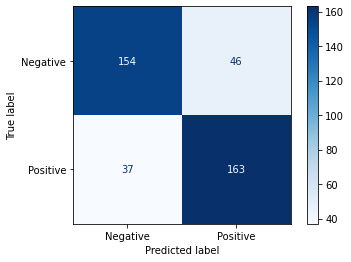

In [30]:
"""
cm = confusion_matrix(cond_inp, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
disp.plot()
plt.show()
"""
ConfusionMatrixDisplay.from_predictions(cond_inp, y_pred, cmap=plt.cm.Blues, display_labels=target_names)
print(classification_report(cond_inp, y_pred, target_names=target_names))